In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('https://github.com/NataliaNovosad/time-series-analysis/blob/master/time-series-datasets/Electric_Production.csv?raw=true')

### **Завдання 20** (7 балів)

Виконайте **мультиплікативну** декомпозицію часового ряду вручну. Використовуйте ті ж самі параметри, які ми використовували для адитивної - тренд з MA(24) і сезонність на 12. Намалюйте на 1 графіку оригінальний ряд і результати мультиплікативної моделі. Чи дана модель краще пояснює дані ніж адитивна? Чому?

In [124]:
# download data
df = pd.read_csv('https://github.com/NataliaNovosad/time-series-analysis/blob/master/time-series-datasets/Electric_Production.csv?raw=true')
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")

In [125]:
df["TREND"] = df["IPG2211A2N"].rolling(window = 24, center = True, min_periods = 1).mean()
df["NO_TREND"] = df["IPG2211A2N"] / df["TREND"]
df

,DATE,IPG2211A2N,TREND,NO_TREND
0,1985-01-01,72.5052,62.165667,1.166322
1,1985-02-01,70.6720,63.022592,1.121376
2,1985-03-01,62.4502,63.377186,0.985374
3,1985-04-01,57.4714,63.300180,0.907918
4,1985-05-01,55.3151,62.908475,0.879295
...,...,...,...,...
392,2017-09-01,98.6154,103.097218,0.956528
393,2017-10-01,93.6137,103.118062,0.907830
394,2017-11-01,97.3359,103.893487,0.936882
395,2017-12-01,114.7212,104.679450,1.095929


In [126]:
df["MONTH"] = df["DATE"].dt.month
df_group = df.groupby("MONTH")["NO_TREND"].mean()
df_group = pd.DataFrame(df_group).rename(columns = {"NO_TREND": "SEASON_12"})
df = df.merge(df_group, left_on = "MONTH", right_index = True)
df = df.sort_values("DATE")

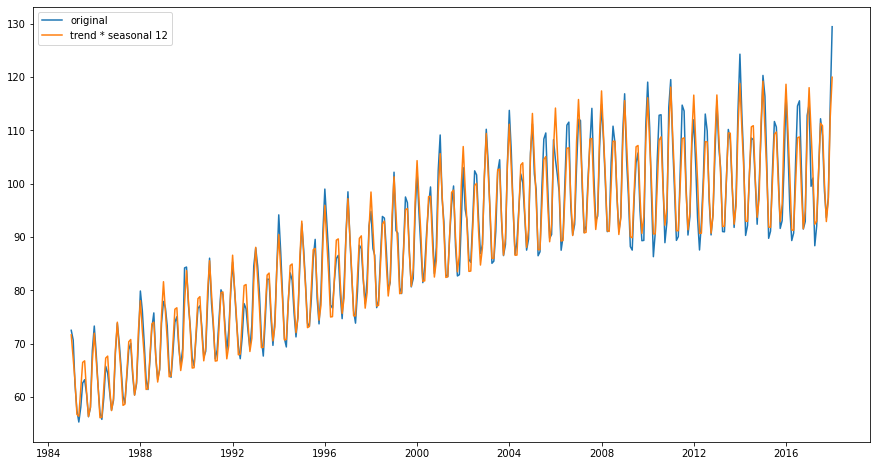

In [127]:
plt.figure(figsize = (15,8))
plt.plot(df["DATE"], df["IPG2211A2N"], label = "original")
#plt.plot(df["DATE"], df["TREND"], label = "trend")
#plt.plot(df["DATE"], df["NO_TREND"], label = "No trend")
plt.plot(df["DATE"], df["TREND"]*df["SEASON_12"], label = "trend * seasonal 12")
plt.legend()
plt.show()

У цьому випадку мультиплікативна модель краще пояснює дані ніж адитивна, оскільки враховує зміни у динаміці піків сезонності. У адитивній моделі на початку часового ряду очікувані показники перевищували реальні, а в кінці, навпаки, були меншими. Тут результати значно краще відображають дані, хоча також у останній третині піки у моделі менші за реальні.

Ще один показник покращення моделі, це зменшення residuals, яке видно в графіках модулю statsmodels, тобто коливань, які не враховані у відображення сезонності тут менше.
(хоча я не зовсім зрозуміла, чому у такому разі у seasonal не показана динаміка, яку ми бачимо у графіку моделі, побудованої вручну)

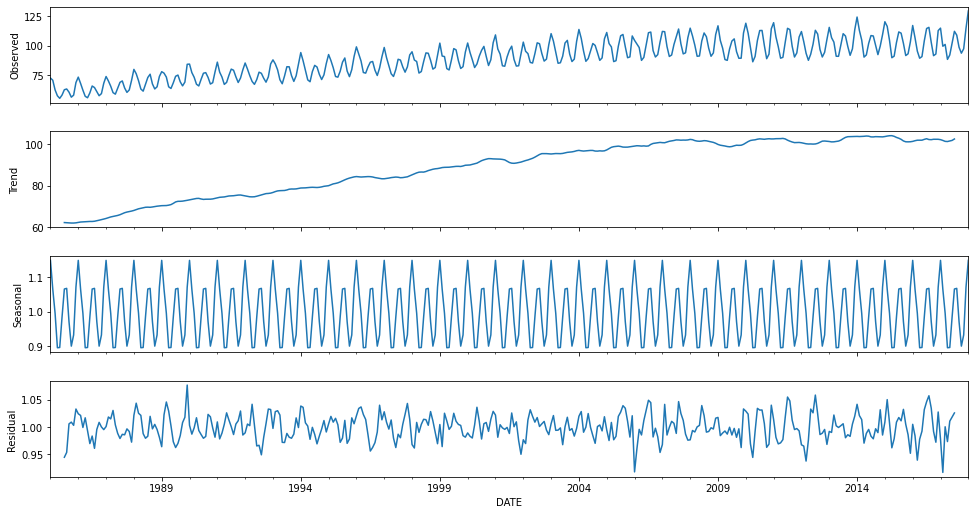

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(df.set_index("DATE")["IPG2211A2N"], model = 'multiplicative', freq=12)
fig = sd.plot()
fig.set_size_inches(15,8)
plt.show()

In [69]:
sd.resid.std()

0.02383213591126165

### **Завдання 21** (5 балів)

Побудуйте модель Holt Winters для нових даних. Намалюйте прогнози на графіку та подивітьс на параметри моделі. Прокоментуйте модель. З чим модель впоралась? З чим ні? Як можна її покращити?

In [63]:
df = pd.read_csv('https://github.com/NataliaNovosad/time-series-analysis/blob/master/time-series-datasets/monthly-beer-production-in-austr.csv?raw=true')

In [64]:
df["DATE"] = pd.to_datetime(df["Month"])
df = df.drop("Month", axis = 1)
df.head(13)

,Monthly beer production,DATE
0,93.2,1956-01-01
1,96.0,1956-02-01
2,95.2,1956-03-01
3,77.1,1956-04-01
4,70.9,1956-05-01
5,64.8,1956-06-01
6,70.1,1956-07-01
7,77.3,1956-08-01
8,79.5,1956-09-01
9,100.6,1956-10-01


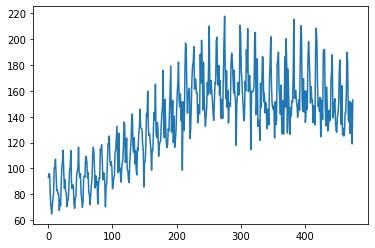

In [55]:
df["Monthly beer production"].plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


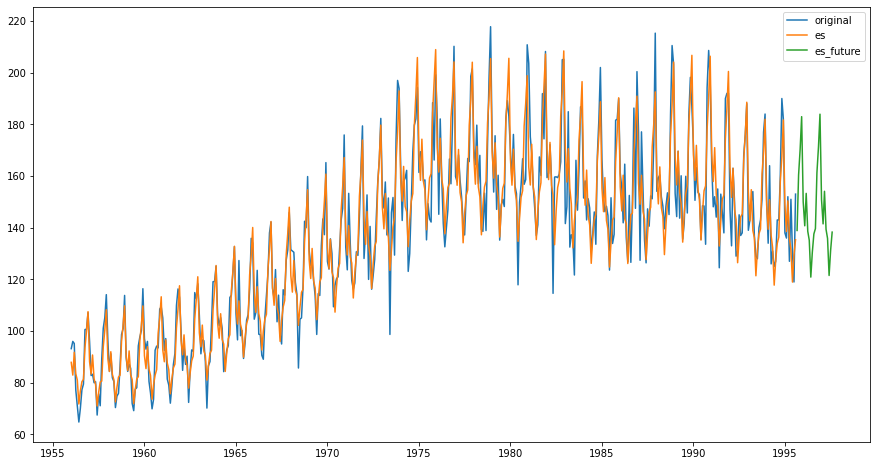

In [85]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw = ExponentialSmoothing(df.set_index("DATE")["Monthly beer production"], 
                          seasonal_periods = 12,
                          trend="mul",
                          seasonal="mul"
                          ).fit()
predictions = hw.predict(start = df["DATE"].min(), end = df["DATE"].max())
future_dates = pd.date_range(start = df["DATE"].max() + pd.DateOffset(months = 1), end = df["DATE"].max() + pd.DateOffset(months = 24
                                                                                                                          ), freq = "MS")
predictions_future = hw.predict(start = future_dates.min(), end = future_dates.max())

df = df.sort_values("DATE")
plt.figure(figsize = (15,8))
plt.plot(df["DATE"], df["Monthly beer production"], label = "original")
plt.plot(df["DATE"], predictions, label = "es")
plt.plot(future_dates, predictions_future, label = "es_future")
plt.legend()
plt.show()

In [67]:
hw.params

{'damping_trend': nan,
 'initial_level': 129.4021316763951,
 'initial_seasons': array([0.67847374, 0.63614744, 0.69254057, 0.62605998, 0.61011936,
        0.54542811, 0.58840117, 0.62018783, 0.62935434, 0.72637553,
        0.77107904, 0.8277645 ]),
 'initial_trend': 1.0011392721194996,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.0851936802473158,
 'smoothing_seasonal': 5.915540233904523e-09,
 'smoothing_trend': 0.08519296469930919,
 'use_boxcox': False}

Модель дуже добре передбачила нелінійні зміни у тренді: перехід від зростання до рівномірного коливання. Дещо в меншій мірі правильно вона відображає сезонні коливання, оскільки хоча і добре показує зміну в їх амплітуді (для цього я використала мультиплікативну модель), але не враховує нерегулярні піки. Параметри альфа здається підібрані найбільш оптимально, щонайменш їх зміна не покращувала модель. Вона прогнозує поступове зростання тренду на основі другої частини даних. Проте, сезонність у прогнозованому ряді залишається однаковою, що не схоже на те, що ми спостерігали у минулому

### **Завдання 22 (додатково)** (10 балів)

Для правильної валідації моделі потрібно лишити дані вкінці ряду для оцінки прогнозу. Обріжте ряд та лишіть 3 останні роки для валідації. На першій частині даних побудуйте модель Holt Winters. Зробіть прогнози на 3 роки вперед та намалюйте їх разом з оригінальними даними. Крім того, обрахуйте рівень помилки MAPE. Прокоментуйте точність моделі. 

За бажанням можна спробувати реалізувати похибку Theil’s U за [формулою](https://docs.oracle.com/cd/E57185_01/CBREG/ch06s02s03s04.html)

In [20]:
df_train = df[df.DATE.dt.year < 1993]
df_test = df[df.DATE.dt.year >= 1993]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


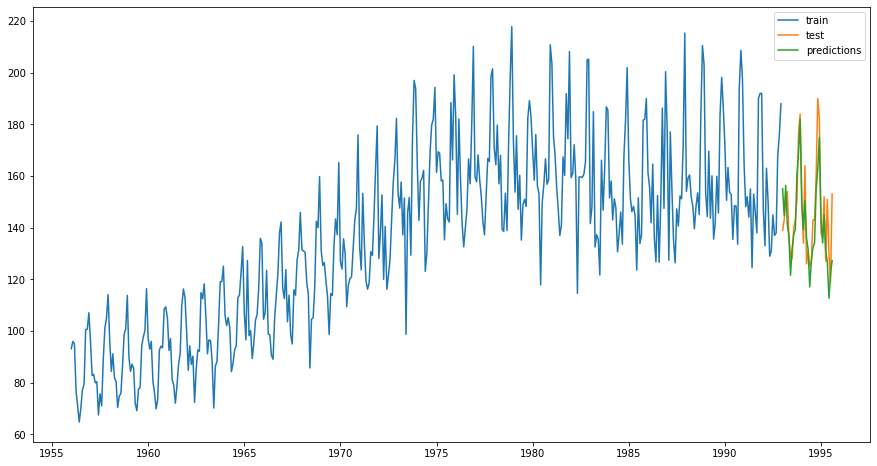

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw = ExponentialSmoothing(df_train.set_index("DATE")["Monthly beer production"], 
                          seasonal_periods = 12,
                          trend="mul",
                          seasonal="mul"
                          ).fit()

#predictions = hw.forecast(72)
predictions = hw.predict(start = df_test["DATE"].min(), end = df_test["DATE"].max())

plt.figure(figsize = (15,8))
plt.plot(df_train["DATE"], df_train["Monthly beer production"], label = "train")
plt.plot(df_test["DATE"], df_test["Monthly beer production"], label = "test")
plt.plot(predictions.index, predictions, label = "predictions")
plt.legend()
plt.show()

In [48]:
def mape(y_t, y_p):
    mape = np.mean(np.abs((y_t - y_p) / y_t)) * 100
    return mape

In [50]:
mape(y_t = df_test['Monthly beer production'], y_p = np.array(predictions))

5.503971619859498

Відсоток похибки виглядає досить низьким, тому можна стверджувати, що модель досить достовірно прогнозує дані

Функцію Theil’s U, я писала не сама, а використала з цієї статті https://fischerbach.medium.com/forecast-evaluation-statistics-with-examples-in-python-6b540ef751c2, оскільки все ж було цікаво подивитись які результати вона дасть. Цей показник є досить невеликим, що також свідчить на користь того, що дана модель добре справляється із прогнозуванням

In [51]:
def u2(f,y):
    df = pd.DataFrame({'f_i+1':f, 'y_i+1': y})
    df['y_i'] = df['y_i+1'].shift(periods=1)
    df['numerator'] = np.square((df['f_i+1'] - df['y_i+1']) / df['y_i'])
    df['denominator'] = np.square((df['y_i+1'] - df['y_i']) / df['y_i'])
    df.dropna(inplace=True)
    return np.sqrt(np.sum(df['numerator'])/np.sum(df['denominator']))

In [52]:
u2(f=np.array(predictions), y=df_test['Monthly beer production'])

0.5919561883681487